In [ ]:
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_final = pd.read_csv("../data/csv/df_final.csv")
df_final.head()

,paperId,docType,keywords,keywordsPlus,subjectSub1,subjectCat1,subjectCatExt,categoryHeading,abstract,year,...,title,country,location,orgNames,orgEnhanced1,orgEnhancedAll,fullName,researcherId,authorSeq,firstAuthorSource
0,WOS:000400551000003,Article,"computational materials science,nanostructures...",NaN,Technology,"Materials Science, Multidisciplinary",Materials Science,Science & Technology,Nanomaterial-based ultra-low-energy device des...,2016,...,Towards quantum dot and device implementation ...,India,NaN,West Bengal Univ Technol,Maulana Abul Kalam Azad University of Technology,Maulana Abul Kalam Azad University of Technology,"Purkayastha, Tamoghna",FSQ-0224-2022,1,seq1_unique
1,WOS:000400701200001,Article,NaN,NaN,Physical Sciences,"Physics, Applied",Physics,Science & Technology,A challenge for constructing large circuits of...,2016,...,Universal Gate for Fixed-Frequency Qubits via ...,USA,AP,IBM TJ Watson Res Ctr,International Business Machines (IBM),International Business Machines (IBM);IBM USA,"McKay, David C.",GWM-2403-2022,1,seq1_unique
2,WOS:000399549500014,Article,NaN,"PASTA-ULAM PROBLEM,1-F NOISE,THERMAL AGITATION...",Technology,"Computer Science, Theory & Methods","Computer Science,Instruments & Instrumentation...",Science & Technology,Fluctuations with 1/f spectrum stand for the f...,2016,...,On the 1/f Noise and Energy Partition in Solid,Romania,AC,IMT Bucharest,National Institute Research & Development Micr...,National Institute Research & Development Micr...,"Mihaila, M.",FKV-4690-2022,1,seq1_unique
3,WOS:000397944800010,Article,"Quantum Key Distribution,Bell States,Quantum C...","PRIVACY AMPLIFICATION,CRYPTOGRAPHY,INFORMATION...",Technology,"Computer Science, Information Systems",Computer Science,Science & Technology,A quantum key distribution protocol with tradi...,2016,...,Semi-quantum Key Distribution Protocol Based o...,Peoples R China,AC,Shenzhen Univ,Shenzhen University,Shenzhen University,"Wang, Ting",JUD-9931-2023,1,seq1_unique
4,WOS:000398221800009,Article,"quantum cryptography,authentication,key distri...",NaN,Technology,"Computer Science, Information Systems","Computer Science,Telecommunications",Science & Technology,"In this paper, we review a previous research p...",2016,...,Upgrade of a quantum scheme for authentication...,Tunisia,NaN,Natl Engn Sch Tunis,Universite de Tunis-El-Manar,Universite de Tunis-El-Manar;Ecole Nationale d...,"Ghilen, Aymen",GAU-3999-2022,1,seq1_unique


In [8]:
#https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/48b93f3c-fb3f-472b-8a13-28a63a423d5f/content

# Initialize tokenizer, lemmatizer, and stopwords
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(text.lower())
    tokens = [t for t in tokens if not t.isnumeric()]       # Remove pure numbers
    tokens = [t for t in tokens if len(t) > 1]              # Remove 1-char tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return tokens

# Preprocess each abstract as one document
docs = df_final['abstract'].apply(preprocess).tolist()

# Build bigrams model (with min_count=20)
bigram = Phrases(docs, min_count=20, threshold=10)

# Append bigrams to documents
docs_with_bigrams = []
for doc in docs:
    bigrams_in_doc = [token for token in bigram[doc] if '_' in token]
    docs_with_bigrams.append(doc + bigrams_in_doc)

# Train trigram model (min_count and threshold can be tuned)
trigram = Phrases(docs_with_bigrams, min_count=20, threshold=10)

# Append trigrams to documents
docs_with_trigrams = []
for doc in docs_with_bigrams:
    trigrams_in_doc = [token for token in trigram[doc] if '_' in token]
    docs_with_trigrams.append(doc + trigrams_in_doc)

# Create dictionary and filter extremes (remove tokens appearing <20 docs)
dictionary = Dictionary(docs_with_trigrams)
dictionary.filter_extremes(no_below=20, no_above = 0.3) #no_above

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in docs_with_trigrams]

print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")


Number of unique tokens: 9043
Number of documents: 28033


In [9]:
# Get (token, doc_freq) pairs
token_freqs = [(dictionary[id], freq) for id, freq in dictionary.dfs.items()]

# Sort descending by frequency
token_freqs_sorted = sorted(token_freqs, key=lambda x: x[1], reverse=True)

# Show top 10 tokens with their document counts
for token, freq in token_freqs_sorted[:100]:
    print(f"Token: '{token}', Document Frequency: {freq}")

Token: 'result', Document Frequency: 8357
Token: 'used', Document Frequency: 8229
Token: 'single', Document Frequency: 7354
Token: 'also', Document Frequency: 7256
Token: 'one', Document Frequency: 7153
Token: 'optical', Document Frequency: 6812
Token: 'time', Document Frequency: 6630
Token: 'high', Document Frequency: 6547
Token: 'field', Document Frequency: 6527
Token: 'photon', Document Frequency: 6201
Token: 'use', Document Frequency: 6123
Token: 'device', Document Frequency: 5978
Token: 'method', Document Frequency: 5932
Token: 'measurement', Document Frequency: 5660
Token: 'present', Document Frequency: 5542
Token: 'scheme', Document Frequency: 5366
Token: 'key', Document Frequency: 5294
Token: 'processing', Document Frequency: 5288
Token: 'computing', Document Frequency: 5287
Token: 'demonstrate', Document Frequency: 5234
Token: 'study', Document Frequency: 5067
Token: 'protocol', Document Frequency: 5024
Token: 'technology', Document Frequency: 4998
Token: 'work', Document Freq

In [ ]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    num_topics=10,
    passes=20,
    eval_every=None)

#5m 1.3s


In [13]:
lda_model.save('../data/model/lda_model.model')

In [14]:
lda_model.show_topics(formatted=False)

[(0,
  [('quantum_mechanic', 0.018722482),
   ('nd', 0.016486153),
   ('theory', 0.01573949),
   ('matrix', 0.008232132),
   ('information_theory', 0.008011104),
   ('public_key', 0.0075814705),
   ('measurement', 0.0070961616),
   ('mechanic', 0.006778427),
   ('well_known', 0.006706779),
   ('result', 0.0066291685)]),
 (1,
  [('algorithm', 0.01769726),
   ('computing', 0.011912451),
   ('machine_learning', 0.011632534),
   ('problem', 0.0105600925),
   ('device', 0.009218474),
   ('classical', 0.00907009),
   ('circuit', 0.008215014),
   ('method', 0.008111696),
   ('computer', 0.00793097),
   ('quantum_computing', 0.007843199)]),
 (2,
  [('atom', 0.009966304),
   ('time', 0.00896891),
   ('field', 0.008489876),
   ('cavity', 0.008367408),
   ('information_processing', 0.008299926),
   ('control', 0.0077406648),
   ('time_dependent', 0.007615206),
   ('heisenberg_uncertainty', 0.007156097),
   ('coupling', 0.006913221),
   ('interaction', 0.0066244365)]),
 (3,
  [('many_body', 0.0102

In [21]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, '../data/html/lda_visualization.html')


In [16]:
import gensim
from gensim.models import CoherenceModel

def compute_coherence_values_lda_model(dictionary, corpus, texts, limit, start=2, step=6):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of tokenized texts (your preprocessed documents)
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lda = []
    model_list_lda = []

    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            chunksize=2000,
            alpha='auto',
            eta='auto',
            iterations=400,
            passes=20,
            eval_every=None
        )

        model_list_lda.append(lda_model)

        coherencemodel_lda = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values_lda.append(coherencemodel_lda.get_coherence())

    return model_list_lda, coherence_values_lda


In [17]:
model_list, coherence_values = compute_coherence_values_lda_model(
    dictionary=dictionary,
    corpus=corpus,
    texts=docs_with_trigrams,
    start=2,
    limit=40,
    step=6
)

#42 m 

/Users/norika_machome/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norika_machome/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norika_machome/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norika_machome/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, current

In [19]:
coherence_values

[0.37076054734973984,
 0.5244474788337663,
 0.5271569022752595,
 0.5195902580209475,
 0.4945877942553356,
 0.4922282198689864,
 0.47054773610341544]

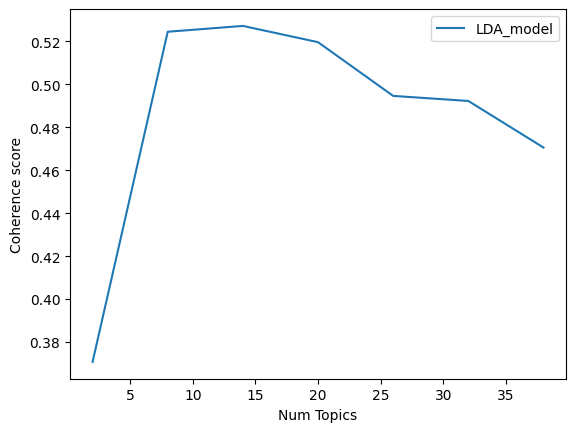

Num Topics = 2  has Coherence Value of 0.3708
Num Topics = 8  has Coherence Value of 0.5244
Num Topics = 14  has Coherence Value of 0.5272
Num Topics = 20  has Coherence Value of 0.5196
Num Topics = 26  has Coherence Value of 0.4946
Num Topics = 32  has Coherence Value of 0.4922
Num Topics = 38  has Coherence Value of 0.4705


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
y_lda = coherence_values

plt.plot(x, y_lda, label='LDA_model')


plt.xlabel("Num Topics")
plt.ylabel("Coherence score")    
plt.legend()
plt.savefig('../data/model/model_lda_coherence_score.png')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [26]:
# Train final LDA model with 14 topics
num_topics = 14
lda_model_14 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    passes=20,
    eval_every=None
)

# Print the top 10 keywords for each topic
for i, topic in lda_model_14.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {i+1}:")
    print(", ".join([word for word, prob in topic]))
    print()



Topic 1:
optical, photon, information_processing, high, mode, high_dimensional, loss, communication, photonic, fiber

Topic 2:
key, key_distribution, protocol, scheme, qkd, security, distribution, attack, secret_key, cv_qkd

Topic 3:
mode, cavity, noise, coupling, information_processing, frequency, experimentally_demonstrate, measurement, resonator, two_level

Topic 4:
algorithm, method, computing, state_art, quantum_computing, model, computer, classical, circuit, approach

Topic 5:
entanglement, entangled_state, entangled, measurement, error_correction, teleportation, protocol, bell, bell_state, code

Topic 6:
single_photon, photon, single, detector, source, high, photonic, integrated, emitter, technology

Topic 7:
many_body, ground_state, topological, atom, interaction, phase, model, spin, many, ground

Topic 8:
optical, field, laser, light, potential_application, wave, information_processing, three_level, zero_phonon, excited_state

Topic 9:
control, time, spin, coherence_time, cohe

In [25]:
# Visualize with pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model_14, corpus, dictionary)
pyLDAvis.save_html(vis, '../data/html/lda_model_14_visualization.html')

# Save the model to a file
lda_model_14.save('../data/model/lda_model_14topics.model')

# # Later, to load the model
# from gensim.models.ldamodel import LdaModel
# loaded_lda_model = LdaModel.load('lda_model_14topics.model')

# et_al, nd, well_known

### Experiments

In [34]:
from collections import Counter

# Define no_above values to test
no_above_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]

for no_above in no_above_values:
    # Create dictionary from docs_with_bigrams for each no_above value
    dictionary = Dictionary(docs_with_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=no_above)
    
    print(f"\n--- no_above = {no_above} ---")
    print(f"Number of unique tokens: {len(dictionary)}")
    
    # Get top 100 tokens by document frequency (descending)
    token_counts = [(dictionary[id], freq) for id, freq in dictionary.dfs.items()]
    token_counts.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 100 tokens by document frequency:")
    for token, freq in token_counts[:100]:
        print(f"Token: '{token}', Document Frequency: {freq}")



--- no_above = 0.1 ---
Number of unique tokens: 8557
Top 100 tokens by document frequency:
Token: 'source', Document Frequency: 2741
Token: 'dynamic', Document Frequency: 2737
Token: 'coherent', Document Frequency: 2736
Token: 'analysis', Document Frequency: 2700
Token: 'case', Document Frequency: 2696
Token: 'design', Document Frequency: 2680
Token: 'frequency', Document Frequency: 2672
Token: 'function', Document Frequency: 2665
Token: 'scale', Document Frequency: 2632
Token: 'resource', Document Frequency: 2602
Token: 'via', Document Frequency: 2597
Token: 'range', Document Frequency: 2549
Token: 'generation', Document Frequency: 2542
Token: 'single_photon', Document Frequency: 2536
Token: 'security', Document Frequency: 2533
Token: 'computation', Document Frequency: 2528
Token: 'long', Document Frequency: 2519
Token: 'provides', Document Frequency: 2483
Token: 'atom', Document Frequency: 2481
Token: 'possible', Document Frequency: 2480
Token: 'open', Document Frequency: 2468
Token